# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os
import random
import json

In [2]:
# Install nb_black for autoformatting
!pip install nb_black --quiet
%load_ext lab_black

In [3]:
tf.__version__

'2.11.0'

# Set-up & Reproducible

In [4]:
# Constante
SEED = 42
ROWS_PER_FRAME = 543
data_dir = "/kaggle/input/asl-signs"
landmark_fimes_dir = "/kaggle/input/asl-signs/train_landmark_files"

In [5]:
def seed_it_all(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_it_all()  # Reproducible

In [6]:
def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [7]:
def read_json(path):
    with open(path, "r") as file:
        json_data = json.load(file)
    return json_data

# Load data

In [8]:
path_train_df = pd.read_csv(data_dir + "/train.csv")
path_train_df["path"] = data_dir + "/" + path_train_df["path"]
display(path_train_df.head(2)), len(path_train_df)

,path,participant_id,sequence_id,sign
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait


(None, 94477)

In [9]:
s2p_map = read_json(os.path.join(data_dir, "sign_to_prediction_index_map.json"))
p2s_map = {v: k for k, v in s2p_map.items()}

encoder = lambda x: s2p_map.get(x)
decoder = lambda x: p2s_map.get(x)

path_train_df["label"] = path_train_df["sign"].map(encoder)
print(f"shape = {path_train_df.shape}")

path_train_df.head(2)

shape = (94477, 5)


,path,participant_id,sequence_id,sign,label
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,232


In [10]:
sample = pd.read_parquet(path_train_df.path[0])
sample.head()

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152


## Herlper function

In [11]:
# let's check the distribution of n_frame over the dataset
distribution_lenght = int(len(path_train_df) / 100)
frames = np.zeros(distribution_lenght)
for index, row in tqdm(path_train_df.iterrows(), total=distribution_lenght):
    if index > distribution_lenght - 1:
        break
    x = load_relevant_data_subset(row.path)
    frames[index] = x.shape[0]

  0%|          | 0/944 [00:00<?, ?it/s]

In [12]:
def tf_nan_mean(x, axis=0):
    x_zero_insted_of_nan = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x_zero_for_nan_else_one = tf.where(
        tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)
    )
    x_out = tf.reduce_sum(x_zero_insted_of_nan, axis=axis) / tf.reduce_sum(
        x_zero_for_nan_else_one, axis=axis
    )
    return tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))


def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

## Configuration

In [13]:
DROP_Z = False
print("Drop Z in data column :", DROP_Z, end="\n\n")

# Drop most of the face landmarks to reduce the dimensionality
LANDMARK = [0, 9, 11, 13, 14, 17, 117, 118, 119, 199, 346, 347, 348] + list(
    range(468, 543)
)

LENGHT_LANDMARK = len(LANDMARK)
N_DATA = len(["x", "y"]) if DROP_Z else len(["x", "y", "z"])
FIXED_FRAME = int(np.median(frames))
SHAPE = [FIXED_FRAME, LENGHT_LANDMARK, N_DATA]

print("Fixed Frame (shape[0]) =", FIXED_FRAME, end="\n\n")
print("Shape =", SHAPE, end="\n\n")

Drop Z in data column : False

Fixed Frame (shape[0]) = 23

Shape = [23, 88, 3]



## Feature Generator

In [14]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        if x.shape[0] is None:  # for inference model
            n_frames = FIXED_FRAME
        else:
            n_frames = x.shape[0]

        # Drop "z" column
        if DROP_Z:
            x = x[:, :, 0:2]

        # NaN values become 0
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

        # Landmarks reduction
        # Select only the usefull landmark
        x = tf.gather(
            x,
            indices=LANDMARK,
            axis=1,
        )

        if FIXED_FRAME > n_frames:
            outputs = tf.image.resize(x, size=[SHAPE[0], SHAPE[1]], method="bilinear")
        else:
            outputs = tf.image.resize(x, size=[SHAPE[0], SHAPE[1]], method="nearest")

        return outputs


feature_converter = FeatureGen()

In [15]:
# Some test
sample = load_relevant_data_subset(path_train_df.path[1])
prepocesse_sample = feature_converter(sample)
prepocesse_sample.shape, sample.shape

(TensorShape([23, 88, 3]), (11, 543, 3))

## Making data

In [16]:
TOTAL_DATA_LENGHT = len(path_train_df)
DATA_LENGHT_EXPERIMENT = int(len(path_train_df) / 10)
print("Lenght of data for modeling :", DATA_LENGHT_EXPERIMENT)
print(f"Percentage of total data {DATA_LENGHT_EXPERIMENT/TOTAL_DATA_LENGHT*100:.1f}%")

Lenght of data for modeling : 9447
Percentage of total data 10.0%


In [17]:
def convert_row(row):
    x = load_relevant_data_subset(row.path)
    x = feature_converter(x)
    return x, row.label


def convert_and_save_data(data_lenght=DATA_LENGHT_EXPERIMENT):
    np_features = np.zeros([data_lenght] + SHAPE)
    np_labels = np.zeros(data_lenght)

    print(f"Total data to processe : {data_lenght}")
    print(f"Percentage of total data {data_lenght/TOTAL_DATA_LENGHT*100:.2f}%")
    for index, row in tqdm(path_train_df.iterrows(), total=data_lenght):
        if index > data_lenght - 1:
            break

        if index % (DATA_LENGHT_EXPERIMENT // 10) == 0:
            print(f"Data processed {index/data_lenght*100:.1f}%")

        data = load_relevant_data_subset(row.path)
        feature, label = convert_row(row)
        np_features[index] = feature
        np_labels[index] = label

    np.save("features.npy", np_features)
    np.save("labels.npy", np_labels)

In [18]:
try:
    features = np.load("/kaggle/working/features.npy")
    labels = np.load("/kaggle/working/labels.npy")
    print("Data Load successfully")
except:
    print("Loading DATA has fail... \nCreating DataSet")
    convert_and_save_data(DATA_LENGHT_EXPERIMENT)

    features = np.load("features.npy")
    labels = np.load("labels.npy")

Loading DATA has fail... 
Creating DataSet
Total data to processe : 9447
Percentage of total data 10.00%


  0%|          | 0/9447 [00:00<?, ?it/s]

Data processed 0.0%
Data processed 10.0%
Data processed 20.0%
Data processed 30.0%
Data processed 40.0%
Data processed 50.0%
Data processed 60.0%
Data processed 69.9%
Data processed 79.9%
Data processed 89.9%
Data processed 99.9%


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=SEED
)

del (
    features,
    labels,
)  # delete, usefull with full data otherwise it fail (memorry issues)

buffer_size = int(DATA_LENGHT_EXPERIMENT / 10)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(128).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(128).prefetch(tf.data.AUTOTUNE)

In [20]:
# Quick test -> after training
quick_test_idx = np.random.randint(0, len(y_val), size=(10,))  # See after training
quick_test_X = np.take(X_val, quick_test_idx, axis=0)
quick_test_y = np.take(y_val, quick_test_idx, axis=0)
del X_train, X_val, y_train, y_val

# Modeling

In [21]:
def dense_block(units, drop):
    fc = layers.Dense(units)
    norm = layers.BatchNormalization()  # أفضل من LayerNorm هنا
    act = layers.Activation("relu")
    dropout = layers.Dropout(drop)
    return lambda x: dropout(act(norm(fc(x))))


def classifier(lstm_units, n_labels, drop):
    lstm = layers.ConvLSTM1D(
        filters=lstm_units,
        kernel_size=3,  # بدل 1 عشان يشوف سياق زمني
        padding="same",
        return_sequences=False,
    )
    dropout = layers.Dropout(drop)
    flat = layers.Flatten()

    hidden = layers.Dense(512, activation="relu")  # Hidden layer إضافي
    hidden_dropout = layers.Dropout(drop)

    dense = layers.Dense(n_labels)
    outputs = layers.Activation("softmax", dtype="float32", name="predictions")

    return lambda x: outputs(dense(hidden_dropout(hidden(flat(dropout(lstm(x)))))))


def get_model(
    encoder_units=[128, 64],
    drop=0.5,
    lstm_units=256,
    n_labels=250,
    shape=SHAPE,
    learning_rate=0.0003,  # قللنا الـ LR
):
    inputs = layers.Input(shape=shape)
    x = inputs

    for units in encoder_units:
        x = dense_block(units, drop)(x)

    outputs = classifier(lstm_units, n_labels, drop)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    return model

In [22]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=8, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "./ASL_model",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=1,
        ),
    ]


cb_list = get_callbacks()

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23, 88, 3)]       0         
                                                                 
 dense (Dense)               (None, 23, 88, 128)       512       
                                                                 
 batch_normalization (BatchN  (None, 23, 88, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 88, 128)       0         
                                                                 
 dropout (Dropout)           (None, 23, 88, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 23, 88, 64)        8256      
                                                             

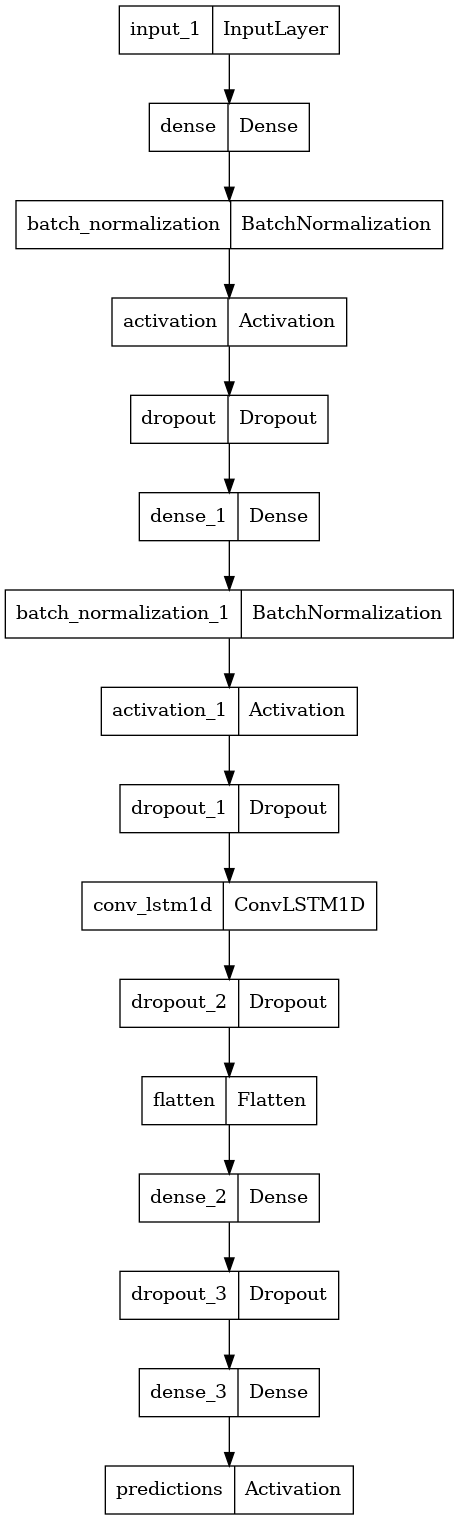

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [24]:
print("Guessing: ", 1 / 250)
print("Data per Class:", DATA_LENGHT_EXPERIMENT / 250)

Guessing:  0.004
Data per Class: 37.788


## Fit

In [25]:
%%time
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=cb_list
)

Epoch 1/50


2026-02-22 09:38:34.729070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/60 [==============================] - ETA: 0s - loss: 5.5535 - accuracy: 0.0049
Epoch 1: val_loss improved from inf to 5.52056, saving model to ./ASL_model
60/60 [==============================] - 74s 1s/step - loss: 5.5535 - accuracy: 0.0049 - val_loss: 5.5206 - val_accuracy: 0.0053 - lr: 3.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 5.5214 - accuracy: 0.0049
Epoch 2: val_loss did not improve from 5.52056
60/60 [==============================] - 62s 1s/step - loss: 5.5214 - accuracy: 0.0049 - val_loss: 5.5207 - val_accuracy: 0.0058 - lr: 3.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 5.5051 - accuracy: 0.0061
Epoch 3: val_loss did not improve from 5.52056
60/60 [==============================] - 61s 1s/step - loss: 5.5051 - accuracy: 0.0061 - val_loss: 5.5366 - val_accuracy: 0.0048 - lr: 3.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 5.4561 - accuracy: 0.0111
Epoch 4: ReduceLROnPlateau 

In [26]:
model = tf.keras.models.load_model("./ASL_model")
score = model.evaluate(val_data)

15/15 [==============================] - 5s 306ms/step - loss: 3.7370 - accuracy: 0.2238


In [27]:
predictions = model.predict(quick_test_X, verbose=False).argmax(axis=1)

for true_label_id, pred_label_id in zip(quick_test_y, predictions):
    true_label = decoder(true_label_id)
    pred_label = decoder(pred_label_id)
    result = True if pred_label == true_label else False
    print(
        f"Prediction on test label : {pred_label.upper():<10} => True label {true_label.upper():<10} => {int(result)}"
    )

Prediction on test label : GRANDMA    => True label MOM        => 0
Prediction on test label : PAJAMAS    => True label CLOSET     => 0
Prediction on test label : HELLO      => True label HELLO      => 1
Prediction on test label : OWL        => True label LOUD       => 0
Prediction on test label : WHY        => True label WHY        => 1
Prediction on test label : BOAT       => True label FEET       => 0
Prediction on test label : DRY        => True label BLACK      => 0
Prediction on test label : HATE       => True label BYE        => 0
Prediction on test label : GRANDPA    => True label GRANDPA    => 1
Prediction on test label : TONGUE     => True label CHEEK      => 0


# Visualize History

In [28]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = n // 2
    col = n // 2 + n % 2

    plt.figure(figsize=(5 * (col + 1) + zoom, 5 * row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col + 1, i + 1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2)  # padding

    plt.subplot(row, col + 1, n + 1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

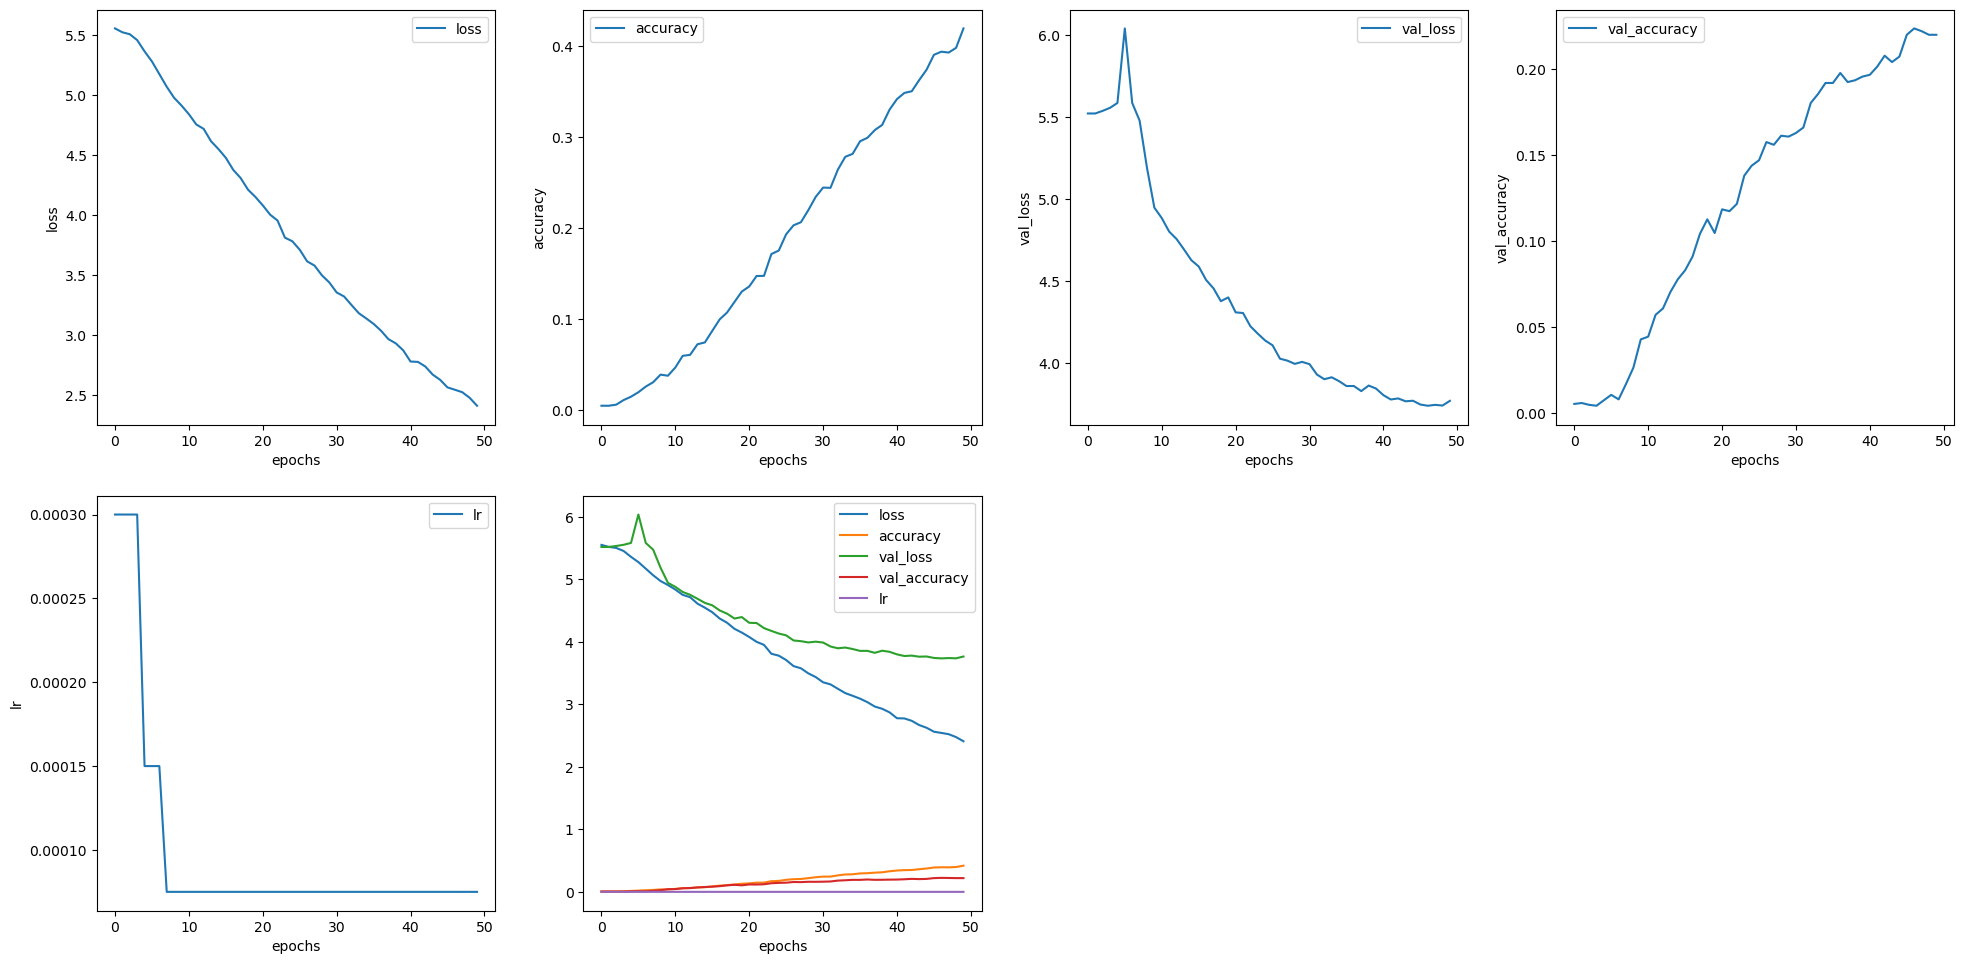

In [29]:
plot_history(history)

# Inference Model

In [30]:
def get_inference_model(model):
    inputs = tf.keras.Input(shape=(543, 3), name="inputs")
    x = feature_converter(inputs)
    x = tf.expand_dims(x, axis=0)
    x = model(x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output)
    inference_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )
    return inference_model

In [31]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 543, 3)]          0         
                                                                 
 feature_gen (FeatureGen)    (23, 88, 3)               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (1, 23, 88, 3)           0         
                                                                 
 model (Functional)          (None, 250)               12656698  
                                                                 
 outputs (Activation)        (1, 250)                  0         
                                                                 
Total params: 12,656,698
Trainable params: 12,656,314
Non-trainable params: 384
_________________________________________________________________


In [32]:
demo_output = inference_model(load_relevant_data_subset(path_train_df.path[0]))
decoder(int(demo_output.numpy().argmax(axis=1)))

'talk'

**Submission Fail**

**TODO : find a way to submite**

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
"""
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]
converter._experimental_lower_tensor_list_ops = False
"""
tflite_model = converter.convert()

model_path = "model.tflite"
# Save the model.
with open(model_path, "wb") as f:
    f.write(tflite_model)

In [34]:
!zip submission.zip $model_path

  adding: model.tflite (deflated 8%)
